1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "data/dog-breed-identification/"
LABELS = "labels.csv"
sz=299
arch=resnext101_64
bs=64

In [3]:
# prepare validation set
rows = len(list(open(PATH+LABELS))) - 1 # -header
val_indexes = get_cv_idxs(rows)

In [4]:
def get_data(ps,bs): 
    tfms = tfms_from_model(arch, ps, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, "train", PATH + LABELS, val_idxs=val_indexes, bs=bs, tfms=tfms, suffix=".jpg", num_workers=4)
    return data if ps > 300 else data.resize(340, 'tmp')

In [5]:
learn = ConvLearner.pretrained(arch, get_data(sz, bs), precompute=True)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|████████▎ | 106/128 [00:01<00:00, 57.70it/s, loss=18.6]


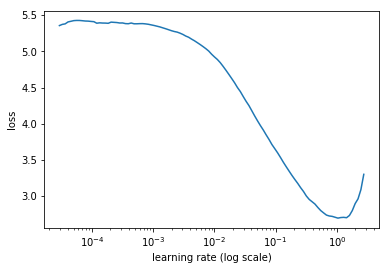

In [6]:
lrf=learn.lr_find()
learn.sched.plot()

In [7]:
learn.fit(0.2, 2) # because when I do [3, cycle_len=1, cycle_mult=2], it overfits very quickly

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.808443   0.428344   0.874316  
    1      0.417456   0.366656   0.896419                    



[0.36665636, 0.8964192699640989]

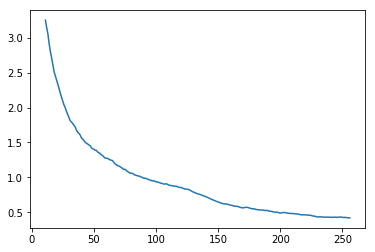

In [8]:
learn.sched.plot_loss()

In [14]:
#learn.precompute=False

In [32]:
learn.save('299_lastlayer_rx101-64')

In [33]:
learn.load('299_lastlayer_rx101-64')

In [34]:
learn.fit(0.01, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.06643    0.277992   0.921322  
    1      0.072258   0.275768   0.920833                     
    2      0.065684   0.274456   0.923763                     
    3      0.076619   0.275576   0.92474                      
    4      0.065543   0.273599   0.925716                     
    5      0.058177   0.273387   0.92474                      
    6      0.063958   0.269287   0.926172                     



[0.2692867, 0.926171874627471]

In [13]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0) #np.exp(log_preds)
# probs = np.exp(log_preds)

In [14]:
(list((np.argmax(probs,1)==y)).count(True)/2044, metrics.log_loss(y, probs))
# previous model: (0.9261252446183953, 0.2695021921211795)
# 3 currentmodel: resx101-64: (0.928082191780822, 0.22163455900024745)

(0.928082191780822, 0.22163455900024745)

In [72]:
learn.save('299_lastlayer_rx101-64-2')

In [75]:
learn.load('299_lastlayer_rx101-64-2')

In [9]:
learn.precompute = False

In [10]:
learn.fit(0.1, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.284945   0.270031   0.923763  
    1      0.260405   0.254717   0.920833                    
    2      0.190279   0.247736   0.922786                    
    3      0.198089   0.267304   0.921842                    
    4      0.180717   0.246252   0.923796                    
  3%|▎         | 4/128 [00:13<07:10,  3.47s/it, loss=0.179]

KeyboardInterrupt: 

In [11]:
learn.save('299_lastlayer_rx101-64-3')

In [12]:
learn.load('299_lastlayer_rx101-64-3')